In [2]:
import pandas as pd
import numpy as np
import csv
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import scipy.integrate as integrate

In [3]:
def get_xy(df, col, row, x_col='all_data'):
    filtered = df[~df.iloc[:, col].isna()]
    return np.array(filtered[x_col])[:row], np.array(filtered.iloc[:, col])[:row]

def sigmoid(x, L ,x0, k, b):
    '''
    L is responsible for scaling the output range from [0,1] to [0,L]
    b adds bias to the output and changes its range from [0,L] to [b,L+b]
    k is responsible for scaling the input, which remains in (-inf,inf)
    x0 is the point in the middle of the Sigmoid, i.e. the point where Sigmoid
    should originally output the value 1/2 [since if x=x0, we get 1/(1+exp(0)) =
    1/2].
    '''
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)


/var/folders/p8/tp5h740x6jq9_1wdwmq91jzh0000gn/T/ipykernel_64890/1642183713.py:14: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0))) + b


0.9943820078630913
0.9933313455520938
0.9864737618444378
0.9954152141877232
0.9948808386256842
0.9974258885166422
0.9946519423841589
0.9960856495132007
0.9935529651871384
0.9958297424650843
0.9950063916153319
0.9969933918910581
0.9986774828092989
0.994025128761351
0.9987173999471721
0.9990049258152045
0.9988182516149932
0.9966949586211296
0.997214406279463
0.9971602391473431
0.9960111577596258
0.9947179474702154
0.9970675303704332
0.9923731275012635
0.9966808061818748
0.9937717316264235
0.9909374105244022
0.9917618802177134
0.9914582707938733
0.9949996770386335
0.9978988226812948
0.9983438676305911
0.9958456903107239
0.9977547781192986
0.9976387944269425
0.9973852039676444
0.993367511113765
0.997786211733111
0.9962486946592513
0.9927157283948393
0.9947029877329391
0.9880123124236688
0.9926253509606625
0.9972080608612874
0.9969461852042979
0.9820208553119495
0.9940932087045619
0.9955125673568105
0.9967421295814054
0.9963692924981622
0.993670632265262
0.9934903803349758
0.99543951719823


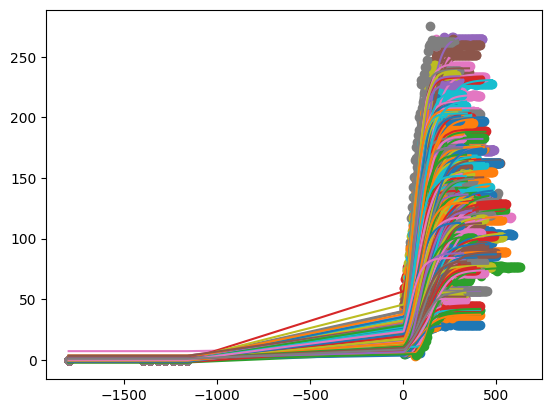

In [4]:
def save_csv(filename):
    df = pd.read_csv(filename)
    outfile = filename[:-4] + '_out.csv'
    with open(outfile, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['L', 'x0', 'k', 'b', 'lf', 'li', 'li2','Lge', 'N','der','L10','L90','r_squared'])
        for col in range(1,129): 
            #yrang=[75,120,120,100,100,100,100,80,70,120,100][col]
            x, y = get_xy(df, col, 2000, x_col='location')
            # Find best guess using grid search
            Ls = np.linspace(0, 400, 10)
            x0s = np.linspace(0, 500, 10)
            ks = np.logspace(np.log10(0.001), np.log10(1), 10)
            bs = np.linspace(-10, 80, 10)
            grid = np.meshgrid(x, Ls, x0s, ks, bs, indexing='ij')
            yhat = sigmoid(*grid)

            # Mean-squared error
            mse = ((yhat - np.expand_dims(y, (1,2,3,4)))**2).mean(axis=0)
            idx = np.unravel_index(np.argmin(mse, axis=None), mse.shape)
            guess = [f[i] for f, i in zip((Ls, x0s, ks, bs), idx)]

            # Optimize guess using curve-fit
            valid = ~(np.isnan(x) | np.isnan(y))
            popt, pcov = curve_fit(sigmoid, x[valid], y[valid], guess, method='lm')
            residuals = y[valid]- sigmoid(x[valid], *popt)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((y[valid]-np.mean(y[valid]))**2)
            r_squared = 1 - (ss_res / ss_tot)
            print(r_squared)
            plt.scatter(x, y)
            plt.plot(x, sigmoid(x, *popt))

            L, x0, k, b = popt
            #Lge = -np.log(1/0.95-1)/k+x0
            Lge = -np.log(1/0.95-1)/k+x0
            L10 = -np.log(1/0.1-1)/k+x0
            L90 = -np.log(1/0.90-1)/k+x0
            #plt.axvline(x=Lge, c='r')
            lf = max(sigmoid(x, *popt))
            li = (y[0]+y[1]+y[2])/3
            li2 = sigmoid(0, *popt)
            N = integrate.quad(lambda x: 1/sigmoid(x, *popt), 0, Lge)[0]
            #derivative
            der=k*L/4
            #(np.exp(-k*(x - x0))*k*L)/(1 + np.exp(-k*(x - x0)))**2
            writer.writerow([L, x0, k, b, lf, li, li2,Lge, N,der,L10,L90,r_squared])
save_csv('/Users/jiey/Desktop/chapter3final/elongation_summary_data.csv')